In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from Transformer import *

# Import the utils from the Time2Vec Transformer
import sys
sys.path.append("../Time2Vec")
from utils import *

import warnings

warnings.filterwarnings('ignore')

daily = pd.read_csv('../../../Dataset/Boulder_Daily.csv')
daily.drop(columns={'Unnamed: 0'}, inplace=True)
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   1668 non-null   float64
 1   Weekday        1668 non-null   object 
 2   Month          1668 non-null   object 
 3   Minimum T      1668 non-null   int64  
 4   Maximum T      1668 non-null   int64  
 5   Snow           1668 non-null   float64
 6   Precipitation  1668 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 91.3+ KB


    Scale the Dataset with MinMaxScaler / One-Hot Encode and Extract the Entire Scaled Dataset

In [3]:
# Define the columns we need to scale and we need to use for One-Hot Encoding
columns_to_scale = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']
categorical_columns = ['Weekday','Month']

# MinMax scaling for numerical columns and One-hot encoding for categorical columns
scaler = MinMaxScaler()
daily_scaled = daily.copy()
daily_scaled[columns_to_scale] = scaler.fit_transform(daily[columns_to_scale])

# One-hot encoding for categorical columns
onehot_encoder = OneHotEncoder(sparse=False)
categorical_encoded = onehot_encoder.fit_transform(daily[categorical_columns])

# Get the feature names from the encoder
encoded_columns = []
for col, values in zip(categorical_columns, onehot_encoder.categories_):
    encoded_columns.extend([f'{col}_{value}' for value in values])

# Create DataFrame with encoded columns
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Concatenate the new encoded columns to the original DataFrame
daily_scaled = pd.concat([daily_scaled, categorical_encoded_df], axis=1)

# Drop the original categorical columns
daily_scaled = daily_scaled.drop(categorical_columns, axis=1)
daily_scaled.columns

Index(['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Month_April', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September'],
      dtype='object')

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [4]:
train_daily_scaled, val_daily_scaled, test_daily_scaled = split_dataset(daily_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.7
Validation split ratio: 0.2
Testing split ratio:    0.101

Shapes of the datasets:
(1167, 24) (333, 24) (168, 24)


    Create sequences for the Transformer model

In [5]:
sequence_length = 120
num_features = len(daily_scaled.columns)

# Create the training, validation, and test data sequences
train_data_inputs, train_data_targets = create_sequences(train_daily_scaled, sequence_length)
val_data_inputs, val_data_targets = create_sequences(val_daily_scaled, sequence_length)
test_data_inputs, test_data_targets = create_sequences(test_daily_scaled, sequence_length)

Dataset split into sequences:
Sequences shape: (1047, 120, 24)
Targets shape: (1047,)

Dataset split into sequences:
Sequences shape: (213, 120, 24)
Targets shape: (213,)

Dataset split into sequences:
Sequences shape: (48, 120, 24)
Targets shape: (48,)



    Create the Transformer Models

In [6]:
# Define the hyperparameters of the manual model
num_heads = 1
d_ff = 64
num_layers = 6
dropout_rate = 0.1
encoder_mask = None
decoder_mask = tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)  # Create a lower triangular mask
decoder_mask = 1 - decoder_mask  # Invert the mask


if __name__ == "__main__":
   manual_model = main(sequence_length, num_features, num_heads, d_ff, num_layers, dropout_rate, encoder_mask, decoder_mask)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 24)]    0           []                               
                                                                                                  
 multi_head_attention_5 (MultiH  (None, None, 24)    2400        ['input_1[0][0]',                
 eadAttention)                                                    'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 dropout_15 (Dropout)           (None, None, 24)     0           ['multi_head_attention_5[0][0]'] 
                                                                                              

In [7]:
# Create the transformer model
input_shape = (sequence_length, num_features)
keras_model = keras_transformer_model(input_shape, num_heads, d_ff, num_layers, dropout_rate)

keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 24)]    0           []                               
                                                                                                  
 multi_head_attention_18 (Multi  (None, 120, 24)     11904       ['input_2[0][0]',                
 HeadAttention)                                                   'input_2[0][0]']                
                                                                                                  
 dropout_43 (Dropout)           (None, 120, 24)      0           ['multi_head_attention_18[0][0]']
                                                                                                  
 layer_normalization_30 (LayerN  (None, 120, 24)     48          ['dropout_43[0][0]']       

    Compile the Models

In [8]:
# Define the learning rate for Adam optimizer
learning_rate = 0.2

# Compile the manual model
manual_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

# Compile the keras model
keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

    Train the Models

In [9]:
# Define the parameters for training
epochs = 60
batch_size = 32

# Convert the data to float32
train_data_inputs = train_data_inputs.astype('float32')
train_data_targets = train_data_targets.astype('float32')

val_data_inputs = val_data_inputs.astype('float32')
val_data_targets = val_data_targets.astype('float32')

train_data_inputs.shape, train_data_targets.shape, val_data_inputs.shape, val_data_targets.shape

((1047, 120, 24), (1047,), (213, 120, 24), (213,))

In [10]:
# Train the manual model
history_manual = manual_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/60
33/33 [==============================] - 9s 115ms/step - loss: 3.3347 - mae: 1.2375 - mse: 3.3347 - root_mean_squared_error: 1.2617 - val_loss: 2.0287 - val_mae: 1.4200 - val_mse: 2.0287 - val_root_mean_squared_error: 1.4221
Epoch 2/60
33/33 [==============================] - 3s 80ms/step - loss: 0.1516 - mae: 0.3024 - mse: 0.1516 - root_mean_squared_error: 0.3461 - val_loss: 1.2610 - val_mae: 1.1174 - val_mse: 1.2610 - val_root_mean_squared_error: 1.1207
Epoch 3/60
33/33 [==============================] - 3s 85ms/step - loss: 0.0548 - mae: 0.1895 - mse: 0.0548 - root_mean_squared_error: 0.2304 - val_loss: 1.6815 - val_mae: 1.2920 - val_mse: 1.6815 - val_root_mean_squared_error: 1.2945
Epoch 4/60
33/33 [==============================] - 3s 78ms/step - loss: 0.0660 - mae: 0.2093 - mse: 0.0660 - root_mean_squared_error: 0.2515 - val_loss: 1.4346 - val_mae: 1.1926 - val_mse: 1.4346 - val_root_mean_squared_error: 1.1955
Epoch 5/60
33/33 [==============================] - 3s 77ms

In [11]:
# Train the keras model
history_keras = keras_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/60
33/33 [==============================] - 85s 2s/step - loss: 2.9154 - mae: 0.9892 - mse: 2.9154 - root_mean_squared_error: 1.0030 - val_loss: 0.4153 - val_mae: 0.6348 - val_mse: 0.4153 - val_root_mean_squared_error: 0.6461
Epoch 2/60
33/33 [==============================] - 60s 2s/step - loss: 0.1128 - mae: 0.2801 - mse: 0.1128 - root_mean_squared_error: 0.3079 - val_loss: 1.3435 - val_mae: 1.1538 - val_mse: 1.3435 - val_root_mean_squared_error: 1.1610
Epoch 3/60
33/33 [==============================] - 59s 2s/step - loss: 0.0280 - mae: 0.1358 - mse: 0.0280 - root_mean_squared_error: 0.1645 - val_loss: 1.5831 - val_mae: 1.2533 - val_mse: 1.5831 - val_root_mean_squared_error: 1.2601
Epoch 4/60
33/33 [==============================] - 59s 2s/step - loss: 0.0842 - mae: 0.2297 - mse: 0.0842 - root_mean_squared_error: 0.2559 - val_loss: 1.1548 - val_mae: 1.0689 - val_mse: 1.1548 - val_root_mean_squared_error: 1.0764
Epoch 5/60
33/33 [==============================] - 58s 2s/step 

    Evaluate the Models

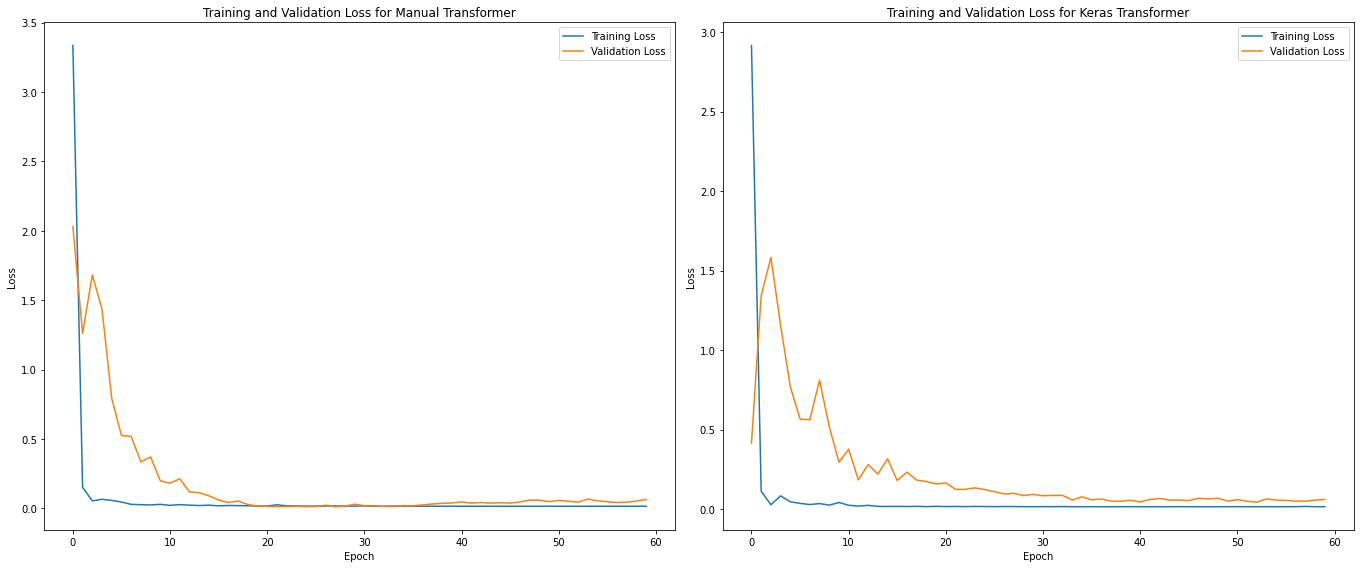

In [12]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss for ' + model_name)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(19, 8))

histories = [history_manual, history_keras]
model_names = ['Manual Transformer', 'Keras Transformer']

for history, model_name, ax in zip(histories, model_names, axes):
    plot_loss(history, model_name, ax)

plt.tight_layout()
plt.show()

In [13]:
# Evaluate on validation set
val_metrics_manual = manual_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)
val_metrics_keras = keras_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)

# Evaluate on test set
test_metrics_manual = manual_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)
test_metrics_keras = keras_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)

# Extract individual metrics
val_loss_manual, val_mae_manual, val_mse_manual, val_rmse_manual = val_metrics_manual['loss'], val_metrics_manual['mae'], val_metrics_manual['mse'], val_metrics_manual['root_mean_squared_error']
test_loss_manual, test_mae_manual, test_mse_manual, test_rmse_manual = test_metrics_manual['loss'], test_metrics_manual['mae'], test_metrics_manual['mse'], test_metrics_manual['root_mean_squared_error']

val_loss_keras, val_mae_keras, val_mse_keras, val_rmse_keras = val_metrics_keras['loss'], val_metrics_keras['mae'], val_metrics_keras['mse'], val_metrics_keras['root_mean_squared_error']
test_loss_keras, test_mae_keras, test_mse_keras, test_rmse_keras = test_metrics_keras['loss'], test_metrics_keras['mae'], test_metrics_keras['mse'], test_metrics_keras['root_mean_squared_error']

print('\n\nManual Transformer:\n-------------------')
print(f'Validation Loss: {val_loss_manual}, Validation MSE: {val_mse_manual}, Validation MAE: {val_mae_manual}, Validation RMSE: {val_rmse_manual}')
print(f'Test Loss: {test_loss_manual}, Test MSE: {test_mse_manual}, Test MAE: {test_mae_manual}, Test RMSE: {test_rmse_manual}')

print('\nKeras Transformer:\n------------------')
print(f'Validation Loss: {val_loss_keras}, Validation MSE: {val_mse_keras}, Validation MAE: {val_mae_keras}, Validation RMSE: {val_rmse_keras}')
print(f'Test Loss: {test_loss_keras}, Test MSE: {test_mse_keras}, Test MAE: {test_mae_keras}, Test RMSE: {test_rmse_keras}')


2/2 [==============================] - 1s 192ms/step - loss: 0.2507 - mae: 0.4802 - mse: 0.2507 - root_mean_squared_error: 0.5042


Manual Transformer:
-------------------
Validation Loss: 0.0650780200958252, Validation MSE: 0.0650780200958252, Validation MAE: 0.2318592518568039, Validation RMSE: 0.2563035190105438
Test Loss: 0.2578379213809967, Test MSE: 0.2578379213809967, Test MAE: 0.48759832978248596, Test RMSE: 0.5112890005111694

Keras Transformer:
------------------
Validation Loss: 0.061748918145895004, Validation MSE: 0.061748918145895004, Validation MAE: 0.224838525056839, Validation RMSE: 0.24967142939567566
Test Loss: 0.250718355178833, Test MSE: 0.250718355178833, Test MAE: 0.48024246096611023, Test RMSE: 0.5042287707328796


In [14]:
# Assuming manual_model.predict returns the predictions
val_predictions_manual = manual_model.predict(val_data_inputs)
test_predictions_manual = manual_model.predict(test_data_inputs)

# Assuming keras_model.predict returns the predictions
val_predictions_keras = keras_model.predict(val_data_inputs)
test_predictions_keras  = keras_model.predict(test_data_inputs)

# Calculate MAE and RMSE for validation set
val_mae_manual = np.mean(np.abs(val_data_targets - val_predictions_manual))
val_rmse_manual = np.sqrt(np.mean(np.square(val_data_targets - val_predictions_manual)))

val_mae_keras  = np.mean(np.abs(val_data_targets - val_predictions_keras ))
val_rmse_keras  = np.sqrt(np.mean(np.square(val_data_targets - val_predictions_keras )))

# Calculate MAE and RMSE for test set
test_mae_manual = np.mean(np.abs(test_data_targets - test_predictions_manual))
test_rmse_manual = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_manual)))

test_mae_keras  = np.mean(np.abs(test_data_targets - test_predictions_keras ))
test_rmse_keras  = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_keras )))


print('\n\nManual Transformer:\n-------------------')
print(f'Validation MAE: {val_mae_manual}')
print(f'Validation RMSE: {val_rmse_manual}')
print(f'\nTest MAE: {test_mae_manual}')
print(f'Test RMSE: {test_rmse_manual}')
print('\n==============================')
print('\nKeras Transformer:\n------------------')
print(f'Validation MAE: {val_mae_keras }')
print(f'Validation RMSE: {val_rmse_keras }')
print(f'\nTest MAE: {test_mae_keras }')
print(f'Test RMSE: {test_rmse_keras }')

2/2 [==============================] - 1s 185ms/step


Manual Transformer:
-------------------
Validation MAE: 0.23185890913009644
Validation RMSE: 0.25510385632514954

Test MAE: 0.4875982821722668
Test RMSE: 0.5077771401856632


Keras Transformer:
------------------
Validation MAE: 0.2248385101556778
Validation RMSE: 0.2484932839870453

Test MAE: 0.4802424425373317
Test RMSE: 0.5007178276326735


In [15]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_predictions_model(model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler):
    # Predictions on training data
    y_pred_train = model.predict(train_data_inputs)
    inversed_y_pred_train = scaler.inverse_transform(np.concatenate([y_pred_train, np.zeros((y_pred_train.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_train = inversed_y_pred_train[:, 0]

    # Inverse the target train data
    train_targets_scaled_data = train_data_targets.reshape(-1,1)
    train_targets_data = scaler.inverse_transform(np.concatenate([train_targets_scaled_data, np.zeros((train_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    train_targets_data = train_targets_data[:, 0]

    # Metrics on training data
    train_rmse = calculate_rmse(train_targets_data, inversed_y_pred_train)
    train_mae = calculate_mae(train_targets_data, inversed_y_pred_train)

    # Predictions on validation data
    y_pred_val = model.predict(val_data_inputs)
    inversed_y_pred_val = scaler.inverse_transform(np.concatenate([y_pred_val, np.zeros((y_pred_val.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_val = inversed_y_pred_val[:, 0]
    
    # Inverse the target validation data
    val_targets_scaled_data = val_data_targets.reshape(-1,1)
    val_targets_data = scaler.inverse_transform(np.concatenate([val_targets_scaled_data, np.zeros((val_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    val_targets_data = val_targets_data[:, 0]

    # Metrics on validation data
    val_rmse = calculate_rmse(val_targets_data, inversed_y_pred_val)
    val_mae = calculate_mae(val_targets_data, inversed_y_pred_val)

    # Predictions on test data
    y_pred_test = model.predict(test_data_inputs)
    inversed_y_pred_test = scaler.inverse_transform(np.concatenate([y_pred_test, np.zeros((y_pred_test.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_test = inversed_y_pred_test[:, 0]

    test_targets_scaled_data = test_data_targets.reshape(-1,1)
    test_targets_data = scaler.inverse_transform(np.concatenate([test_targets_scaled_data, np.zeros((test_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    test_targets_data = test_targets_data[:, 0]

    # Metrics on test data
    test_rmse = calculate_rmse(test_targets_data, inversed_y_pred_test)
    test_mae = calculate_mae(test_targets_data, inversed_y_pred_test)
    
    # Print the results
    print(f"\n\nEvaluation metrics for {model_name} model:\n-------------------")
    print('Train Dataset:')
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}\n-------------------")

    print('Validation Dataset:')
    print(f"RMSE: {val_rmse}")
    print(f"Validation MAE: {val_mae}\n-------------------")
    
    print('Test Dataset:')
    print(f"Test RMSE: {test_rmse}")
    print(f"Test MAE: {test_mae}\n\n")

evaluate_predictions_model(manual_model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler)
evaluate_predictions_model(keras_model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler)

2/2 [==============================] - 0s 14ms/step


Evaluation metrics for Keras Transformer model:
-------------------
Train Dataset:
RMSE: 90.94998311755359
MAE: 73.36830251285554
-------------------
Validation Dataset:
RMSE: 184.90009556572247
Validation MAE: 168.05227706425188
-------------------
Test Dataset:
Test RMSE: 368.03858757727494
Test MAE: 353.41269771330553


2/2 [==============================] - 1s 172ms/step


Evaluation metrics for Keras Transformer model:
-------------------
Train Dataset:
RMSE: 90.39176174911539
MAE: 73.55249151812548
-------------------
Validation Dataset:
RMSE: 180.10868082355802
Validation MAE: 162.96363174697902
-------------------
Test Dataset:
Test RMSE: 362.92178357951065
Test MAE: 348.08116307838577


